<a href="https://colab.research.google.com/github/HaukeSchnepel/shsg_group_7/blob/main/Final_Submission_G7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing modules and mounting the drive

In [1]:
# install flask-ngrock with pip for the web app
!pip install flask-ngrok

In [2]:
from os import path
import os.path
import os
import json
import glob
import shutil

# for video handling
from IPython.display import HTML
from IPython.display import YouTubeVideo
import io
import base64

#to install OpenPose
from os.path import exists, join, basename, splitext

#necessary for flask handling
from flask_ngrok import run_with_ngrok
from flask import Flask, render_template, url_for, request, redirect

#to plot the graphs
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Initialize all the necessary functions

In [4]:
#Run the model over the uploaded video to identify keypoints
def run_model():
  os.chdir('/content')
  !rm -rf video.mp4
  # cuts the first 10 seconds
  !ffmpeg -y -loglevel info -ss 00:00:00.0 -i /content/static/*.mp4 -t 00:00:10.0 video_out.mp4
  # detect poses on the these 10 seconds
  !cd openpose && ./build/examples/openpose/openpose.bin --video ../video_out.mp4 --write_json ./output/ --display 0 --write_video ../openpose.avi
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i openpose.avi output.mp4

#functions to delete folders. E.g. old frames when new video is entered
def empty_folder(folder):
  if path.exists(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
              if file_path != "/content/static/logo.png":
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
            #print("you deleted one frame")
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
  else:
    os.mkdir(folder)

#Main analysis function to process video
def analysis():
  print("Analysis has started")
  #Json are created
  directory = "/content/openpose/output"
  i = 0
  
  #initialize lists where we save the json in 
  right_shoulder_list = []
  left_shoulder_list = []

  # processing json files into lists
  for filename in sorted(os.listdir(directory)):
      filepath = os.path.join(directory, filename)
      with open(filepath,'r') as file:
        data = json.load(file)
        people = data["people"]
        if len(data["people"]) != 0:
          #we take an intermediate step to access the keypoint with a list
          peoples = people[0]
          pose_keypoints = peoples["pose_keypoints_2d"]

          #assign list position of relevant keypoints
          shoulder_right = 2
          shoulder_left = 5

          #multiply list posiiton by three because there are always 3 values for one keypoint
          #these values are x,y coordiantes and probabilities
          #we only retreive x and y coordinates
          s_left = pose_keypoints[shoulder_left*3],pose_keypoints[shoulder_left*3 + 1]
          s_right = pose_keypoints[shoulder_right*3],pose_keypoints[shoulder_right*3 +1]

          #append relevant values to list
          right_shoulder_list.append(s_right)
          left_shoulder_list.append(s_left)
        i += 1
  print("jsons have been created")

  # ----- calc -----
  #in the following part we perform mathematical calculation to track change in postures
  
  # Calculate Distances between shoulders
  i = 0
  distance_list = []
  for ele in right_shoulder_list:
    distance(right_shoulder_list[i],left_shoulder_list[i],distance_list)
    i += 1
  print("distance have been caclulated")

  # Smoothing the values in distance list
  smoothed_distance_list = []
  smoothing_the_list(distance_list, smoothed_distance_list)
  print("distances have been smoothed")

  #Calcualte slopes between shoulders
  slope_list = []
  i = 0
  for ele in right_shoulder_list:
    slope(right_shoulder_list[i], left_shoulder_list[i], slope_list)
    i += 1
  print("slopes have been calculated")

  #Smoothing the values in slope list
  smoothed_slope_list = []
  smoothing_the_list(slope_list, smoothed_slope_list)

  # here we initiate the plotting of the two lists
  plot_smoothed_distance(smoothed_distance_list)
  plot_smoothed_slope(smoothed_slope_list)
  print("plots have been plotted")

## Function to calculate distances and slopes

In [5]:
# function to calc distance
def distance(rs , ls, distance_list):
  x_distance = ls[0] - rs[0]
  #y_distance = ls[1] - rs[1]
  #print(x_distance)
  #print(y_distance)
  distance_list.append(x_distance)

# function to calc slope
def slope(rs, ls, output_list):
  if rs[0] != 0 or ls[0] != 0 or rs[1] != 0 or ls[1] != 0:
    if (ls[0] - rs[0]) == 0:
      print("The line is horizontal")
    else:
      m = (ls[1] - rs[1]) / (ls[0] - rs[0])
      output_list.append(m)

# function to smooth the lists
def smoothing_the_list(list, output_list):
  i = 0
  for element in list:
    if i < (len(list)-2):
      average_value = (list[i-2]+list[i-1]+list[i]+list[i+1]+list[i+2])/5
      output_list.append(average_value)
    elif i < (len(list)-1):
      average_value = (list[i-2]+list[i-1]+list[i]+list[i+1])/4
      output_list.append(average_value)
    elif i == (len(list)-1):
      average_value = (list[i-2]+list[i-1]+list[i])/3
      output_list.append(average_value)
    i += 1

# Plotting the distances
def plot_smoothed_distance(smoothed_distance_list):
  plt.figure(figsize=(30,15), frameon=True)
  plt.plot(smoothed_distance_list)
  plt.title("Smoothed distance between right and left shoulder", fontsize=25)
  plt.xlabel("Time expressed as frames", fontsize=25)
  plt.ylabel("Smoothed distances", fontsize=25)
  plt.savefig('/content/static/distance.png')   # save the figure to file
  print("The distance image was saved")

# Plotting the slope
def plot_smoothed_slope(smoothed_slope_list):
  plt.figure(figsize=(30,15), frameon=True)
  plt.plot(smoothed_slope_list)
  plt.title("Slope", fontsize=25)
  plt.xlabel("Time expressed as frames", fontsize=25)
  plt.ylabel("Smoothed distances", fontsize=25)
  plt.savefig('/content/static/slope.png')   # save the figure to file
  print("The slope image was saved")

## InstalL OpenPose

In [ ]:
#here we access and install the OpenPose model

#from Cao, Z., Hidalgo, G., Simon, T., Wei, S., Sheikh, Y. (2018): 
#OpenPose: Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields. 
#In: arXiv e-prints. https://ui.adsabs.harvard.edu/abs/2018arXiv181208008C.

#we retreive the data from github
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # set build for python
  !cmake -DBUILD_PYTHON=ON
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

### Flask app

**Flask** Main

/content
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4b8834221fec.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [19/Feb/2021 01:10:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2021 01:10:19] "GET /logo.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2021 01:10:26] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/Feb/2021 01:10:41] "POST / HTTP/1.1" 302 -
127.0.0.1 - - [19/Feb/2021 01:10:41] "GET / HTTP/1.1" 200 -


we are now emptying the folder
we are now running the model....
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp

127.0.0.1 - - [19/Feb/2021 01:11:37] "GET /analysis HTTP/1.1" 200 -


The slope image was saved
plots have been plotted
analysis finished


127.0.0.1 - - [19/Feb/2021 01:11:37] "GET /slope.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2021 01:11:37] "GET /distance.png HTTP/1.1" 200 -
127.0.0.1 - - [19/Feb/2021 01:11:50] "GET /output.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [19/Feb/2021 01:11:52] "GET /output.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [19/Feb/2021 01:11:54] "GET /output.mp4 HTTP/1.1" 206 -
127.0.0.1 - - [19/Feb/2021 01:12:18] "GET /output.mp4 HTTP/1.1" 206 -


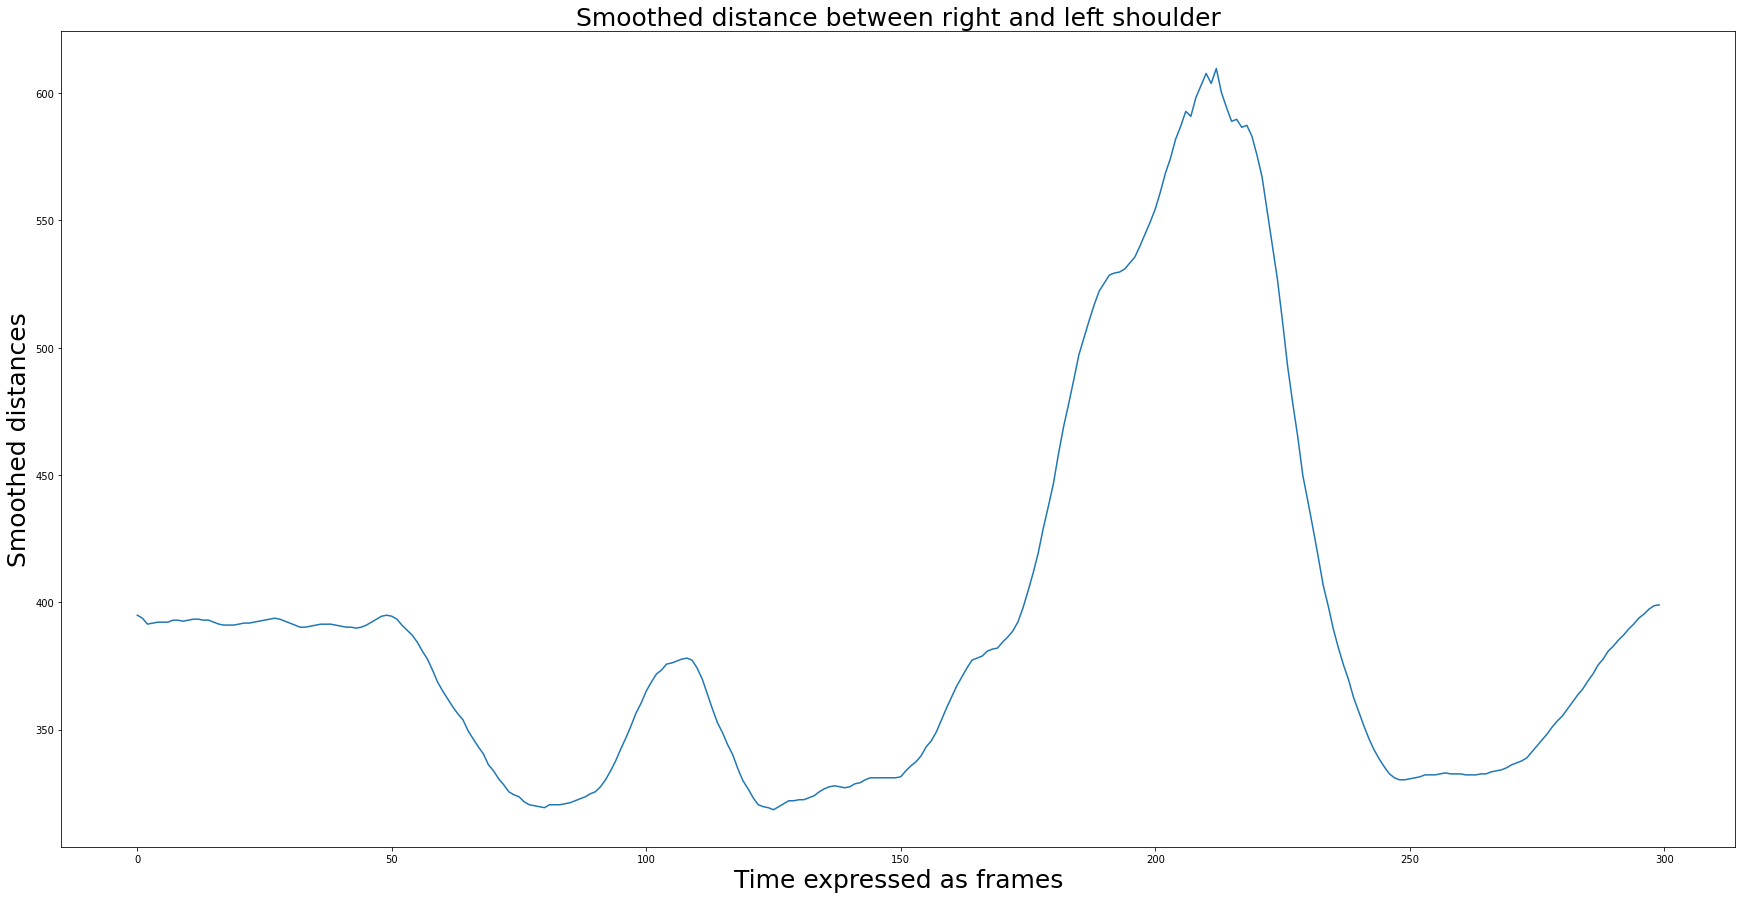

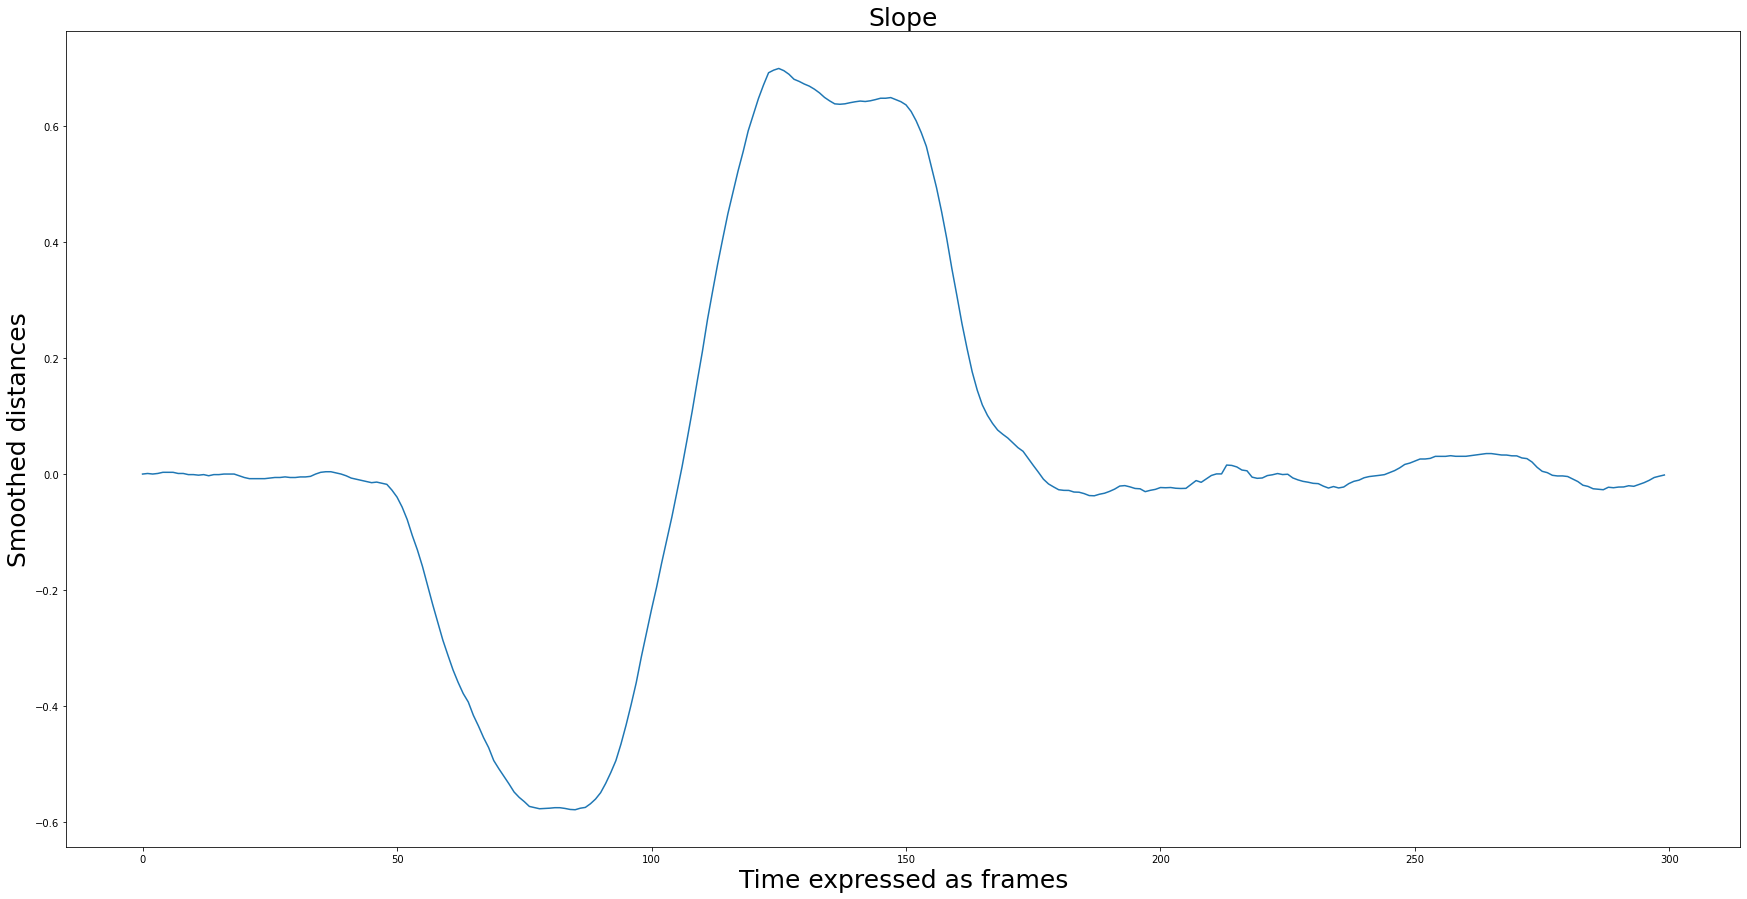

In [12]:
# Here we run Flask to communicate with the webapp
# and call the above functions

# directory "/content"
!pwd

#starts ngrok when the app is running
app = Flask(__name__, static_url_path='/', static_folder='/content/static', template_folder='/content/drive/MyDrive/FlaskApp/templates')
run_with_ngrok(app)

#function to move video into static directory
def move_file(video_name):
  initial_video_path = "/content/" + video_name
  shutil.move(initial_video_path, "/content/static")
  video_path = "/content/static/" + video_name


#function to receive the video from the homepage
@app.route('/', methods=['POST'])
def upload_file():
    empty_folder('/content/static')
    uploaded_file = request.files['file']
    if uploaded_file.filename != '':
        uploaded_file.save(uploaded_file.filename)
        video_name = uploaded_file.filename
        move_file(video_name)
    return redirect(url_for('home'))

# home of the website. e.g. to push logo
@app.route("/")
def home():
    logo = url_for('static', filename='logo.png')
    return render_template("index.html" , pass_logo=logo )

#trigger activated by analysis button to analyse the submitted video
@app.route('/analysis')
def run_analysis():
  print("we are now emptying the folder")
  empty_folder('/content/openpose/output')
  print("we are now running the model....")
  run_model()
  print("we are now starting the analysis")
  analysis()
  print("analysis finished")

  #move video with keypoints to static directory to be uploaded
  move_file("output.mp4")
  #connect video, logo and the two plots with webapp
  userVideo = url_for('static', filename='output.mp4')
  imageslope = url_for('static', filename='slope.png')
  imagedistance = url_for('static', filename='distance.png')
  logo = url_for('static', filename='logo.png')
  return render_template("index.html", user_video1=userVideo , pass_slope=imageslope , pass_distance=imagedistance , pass_logo=logo)

# run the app
app.run()